<h1>Test</h1>
- 병렬노드 테스트
- 참조 소스코드 : https://velog.io/@euisuk-chung/LangChain-Academy-Introduction-to-LangGraph-Module-4

In [2]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

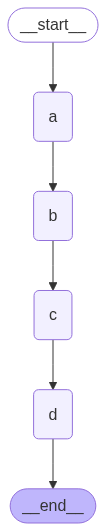

In [3]:
class State(TypedDict):
    # operator.add 리듀서 함수는 이것을 추가 전용으로 만듭니다
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"{self._value}를 {state['state']}에 추가합니다")
        return {"state": [self._value]}

# 노드 추가
builder = StateGraph(State)

# 각 노드를 node_secret으로 초기화 
builder.add_node("a", ReturnNodeValue("나는 A입니다"))
builder.add_node("b", ReturnNodeValue("나는 B입니다"))
builder.add_node("c", ReturnNodeValue("나는 C입니다"))
builder.add_node("d", ReturnNodeValue("나는 D입니다"))

# 흐름
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({"state": ""})

나는 A입니다를 에 추가합니다
나는 B입니다를 ['나는 A입니다']에 추가합니다
나는 C입니다를 ['나는 B입니다']에 추가합니다
나는 D입니다를 ['나는 C입니다']에 추가합니다


{'state': ['나는 D입니다']}

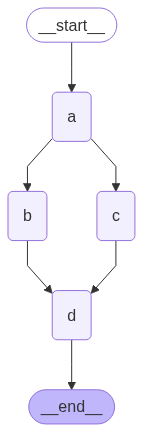

In [5]:
builder = StateGraph(State)

# 각 노드를 node_secret으로 초기화 
builder.add_node("a", ReturnNodeValue("나는 A입니다"))
builder.add_node("b", ReturnNodeValue("나는 B입니다"))
builder.add_node("c", ReturnNodeValue("나는 C입니다"))
builder.add_node("d", ReturnNodeValue("나는 D입니다"))

# 흐름
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# 구조는 위와 같이 쉽게 정의할 수 있지만, 막상 실행해보면, B와 C가 동시에 동일한 상태 키를 업데이트하려 하므로 충돌이 발생하여 에러가 발생하게 됩니다.
graph.invoke({"state": ""})

나는 A입니다를 에 추가합니다
나는 C입니다를 ['나는 A입니다']에 추가합니다
나는 B입니다를 ['나는 A입니다']에 추가합니다


InvalidUpdateError: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

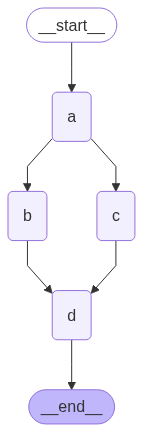

In [7]:
# 병렬 노드 B와 C가 동시에 리스트에 값을 추가하도록 리듀서를 사용하여 상태 충돌을 해결합니다.
# 팬 아웃을 사용할 때는 단계가 동일한 채널/키에 쓰는 경우 리듀서를 사용해야 합니다.
# 모듈 2에서 언급했듯이 operator.add는 Python의 내장 operator 모듈의 함수입니다.
# operator.add가 리스트에 적용되면 리스트 연결을 수행합니다.
import operator
from typing import Annotated

class State(TypedDict):
    # operator.add 리듀서 함수는 이것을 추가 전용으로 만듭니다
    state: Annotated[list, operator.add]

# 노드 추가
builder = StateGraph(State)

# 각 노드를 node_secret으로 초기화 
builder.add_node("a", ReturnNodeValue("나는 A입니다"))
builder.add_node("b", ReturnNodeValue("나는 B입니다"))
builder.add_node("c", ReturnNodeValue("나는 C입니다"))
builder.add_node("d", ReturnNodeValue("나는 D입니다"))

# 흐름
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [8]:
graph.invoke({"state": []})


나는 A입니다를 []에 추가합니다
나는 B입니다를 ['나는 A입니다']에 추가합니다
나는 C입니다를 ['나는 A입니다']에 추가합니다
나는 D입니다를 ['나는 A입니다', '나는 B입니다', '나는 C입니다']에 추가합니다


{'state': ['나는 A입니다', '나는 B입니다', '나는 C입니다', '나는 D입니다']}

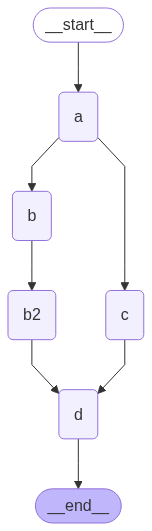

In [9]:
class State(TypedDict):
    # operator.add 리듀서 함수는 이것을 추가 전용으로 만듭니다
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"state": []})

I'm A를 []에 추가합니다
I'm B를 ["I'm A"]에 추가합니다
I'm C를 ["I'm A"]에 추가합니다
I'm B2를 ["I'm A", "I'm B", "I'm C"]에 추가합니다
I'm D를 ["I'm A", "I'm B", "I'm C", "I'm B2"]에 추가합니다


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

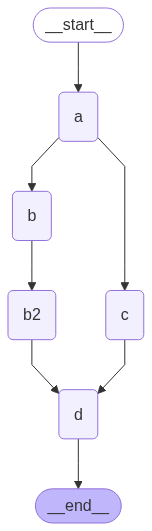

In [14]:
def sorting_reducer(left, right):
    """ 리스트의 값들을 결합하고 정렬합니다"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer는 상태의 값들을 정렬합니다
    state: Annotated[list, sorting_reducer]

# 노드 추가
builder = StateGraph(State)

# 각 노드를 node_secret으로 초기화 
builder.add_node("a", ReturnNodeValue("나는 A입니다"))
builder.add_node("b", ReturnNodeValue("나는 B입니다"))
builder.add_node("b2", ReturnNodeValue("나는 B2입니다"))
builder.add_node("c", ReturnNodeValue("나는 C입니다"))
builder.add_node("d", ReturnNodeValue("나는 D입니다"))

# 흐름
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

